In [123]:
import pickle
import numpy as np
with open('output.pkcl', 'rb') as f:
    d = pickle.load(f)
# Extract the poses with corresponding timestamps from the calibration dataset
stamp = {}
poses = {}
for key in d.keys():
    stamp[key] = np.array([s[0] for s in d[key]])
    poses[key] = np.stack([s[2] for s in d[key]])

In [55]:
from RoboCastingTools.time_sync_utils import getSyncMap
ref_frame = 'Block_14'
# Compute the synchronizing index map between the reference frame and 
# all other frames
maps = {}
for key in stamp.keys():
    if key != ref_frame:
        map = getSyncMap(stamp[ref_frame],stamp[key],threshold=0.01,add_nans=False)
        maps[key] = map

In [122]:
# make a dict to map block names to key IDs and vice versa
name_to_id = {}
id_to_name = {}
for i,key in enumerate(poses.keys()):
    if key.startswith('Block'):
        name_to_id[key]= i
        id_to_name[i] = key


In [124]:
# Use the GTSAM library to find the optimal relative pose between the 
# ref frame and all other frames based on all the relative pose measurements
import gtsam
from gtsam import (
    Pose3,
    Rot3,
    PriorFactorPose3,
    BetweenFactorPose3,
    Point3,
    NonlinearFactorGraph,
    LevenbergMarquardtOptimizer,
)
from gtsam.symbol_shorthand import X

# Create a factor graph
graph = NonlinearFactorGraph()

initial = gtsam.Values()
for key in name_to_id:
    initial.insert(X(name_to_id[key]), gtsam.Pose3())

# Add prior factors for the first two poses
prior_noise = gtsam.noiseModel.Diagonal.Sigmas((0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
graph.add(PriorFactorPose3(X(name_to_id[ref_frame]), Pose3(), prior_noise))

# Add between factors to constrain the poses
between_noise = gtsam.noiseModel.Diagonal.Sigmas((0.01, 0.01, 0.01, 0.01, 0.01, 0.01))

# Add between factor between ref frame and other frames
for key in name_to_id:
    if key != ref_frame:
        ref_pose = poses[ref_frame][maps[key][:,0],...]
        target_pose = poses[key][maps[key][:,1],...]
        for i in range(ref_pose.shape[0]):
            poses[ref_frame][maps[target_key][:,0],...]
            pose1 = Pose3(ref_pose[0,...])
            pose2 = Pose3(target_pose[0,...])
            between12 = pose1.between(pose2)
            graph.add(BetweenFactorPose3(X(name_to_id[ref_frame]), 
                                         X(name_to_id[key]), 
                                         between12, between_noise))

# Optimize the factor graph
params = gtsam.LevenbergMarquardtParams()
optimizer = LevenbergMarquardtOptimizer(graph,initial,params)
optimized_poses = optimizer.optimize()
#Store the results
results = {}
for key in poses:
    if key.startswith('Block'):
        results[key] = optimized_poses.atPose3(X(name_to_id[key])).matrix()
with open('small_tag_calibrateion.pkl', 'wb') as f:
    pickle.dump(results, f)

In [120]:
results

{'Block_1': array([[-0.57957284,  0.81490585,  0.00487638, -0.66538134],
        [-0.8093475 , -0.57629767,  0.11330318, -0.27919199],
        [ 0.09514167,  0.06172076,  0.99354849,  0.00557787],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Block_2': array([[-0.31297061,  0.94885925, -0.04141873, -0.60586589],
        [-0.94678533, -0.30824222,  0.09265135, -0.08490699],
        [ 0.07514609,  0.06821179,  0.99483678,  0.01626335],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Block_3': array([[-0.05277369,  0.99818428, -0.02903602, -0.50167463],
        [-0.99692921, -0.05097823,  0.05944223, -0.18103149],
        [ 0.05785409,  0.03208384,  0.99780937,  0.01273532],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Block_5': array([[ 0.47178743, -0.88170359, -0.00392429, -0.77918241],
        [ 0.87896318,  0.46996056,  0.08099878, -0.0173549 ],
        [-0.06957266, -0.04166351,  0.99670647,  0.01531163],
        [ 0.        

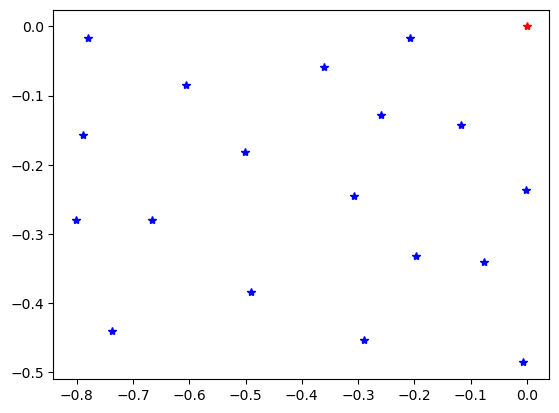

In [125]:
import matplotlib.pyplot as plt
for key in results:
    if key == ref_frame:
        plt.plot(results[key][0,-1], results[key][1,-1], 'r*')
    else:
        plt.plot(results[key][0,-1], results[key][1,-1], 'b*')

In [138]:
tag_size = 0.0765


In [185]:
from scipy.spatial.transform import Rotation
with open('bundle_calibration.txt','w') as f:
    f.write('tag_bundles: \n [ \n    {\n')
    f.write('\t name: ''my_bundle'', \n \t layout: \n \t\t[\n')
    for key in results.keys():
        q = Rotation.from_matrix(results[key][0:3,0:3]).as_quat()
        r = results[key][0:3,-1]        
        f.write(f'\t\t    {{id: {key},\t size: {tag_size},\t x: {r[0]:.4f},\t\t y: {r[1]:.4f},\t\t z: {r[2]:.4f},\t\t qw: {q[3]:.7f},\t\t qx: {q[0]:.7f},\t\t qy: {q[1]:.7f},\t\t qz: {q[2]:.7f}}},\n')
    f.write('\t\t] \n    } \n]\n')

In [148]:
Rotation.from_matrix(np.eye(3)).as_quat()

array([0., 0., 0., 1.])